In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import string
from bs4 import BeautifulSoup
import json
import numpy as np

In [2]:
with open("/content/drive/MyDrive/Sarcasm-Detector/Sarcasm.json",'r') as input:
  data = json.load(input)

In [3]:
## Use NLTK's Stopword List
import nltk
from nltk.corpus import stopwords

nltk.download("stopwords")
stopwords = stopwords.words("english")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [4]:
sarcasm_sentences = []
labels = []
links = []
punctuations = str.maketrans('', '', string.punctuation)
for item in data:
  sentence = item['headline'].lower()
  sentence = sentence.replace(",", " , ").replace(".", " . ").replace("-", " - ").replace("/", " / ")
  sentence = BeautifulSoup(sentence, "html.parser").get_text()

  words = sentence.split()
  filtered_sentence = ""

  for word in words:
    word = word.translate(punctuations)
    if word not in stopwords:
      filtered_sentence += word + " "
  sarcasm_sentences.append(filtered_sentence)
  labels.append(item['is_sarcastic'])
  links.append(item['article_link'])

In [5]:
print(len(sarcasm_sentences))

26709


In [6]:
training_size = 23000
vocab_size = 20000
training_sentences = sarcasm_sentences[0:training_size]
training_labels = labels[0:training_size]
testing_sentences = sarcasm_sentences[training_size:]
testing_labels = labels[training_size:]

In [7]:
tokenizer = Tokenizer(num_words=vocab_size, oov_token="<OOV>")
tokenizer.fit_on_texts(training_sentences)
word_index = tokenizer.word_index
training_sequence = tokenizer.texts_to_sequences(training_sentences)
training_padded = pad_sequences(training_sequence, padding="post")
testing_sequence = tokenizer.texts_to_sequences(testing_sentences)
testing_padded = pad_sequences(testing_sequence, padding="post")

In [8]:
import numpy as np
training_padded = np.array(training_padded)
training_labels = np.array(training_labels).astype(np.float32).reshape(-1)
testing_padded = np.array(testing_padded)
testing_labels = np.array(testing_labels).astype(np.float32).reshape(-1)

In [9]:
model = tf.keras.Sequential([
          tf.keras.layers.Embedding(20000, 16),
          tf.keras.layers.GlobalAveragePooling1D(),
          tf.keras.layers.Dense(24, activation='relu'),
          tf.keras.layers.Dense(1, activation='sigmoid')
        ])
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy']
              )
model.build(input_shape=(None, training_padded.shape[1]))

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 27, 16)         │       320,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d        │ (None, 16)             │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 24)             │           408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            25 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 320,433 (1.22 MB)

 Trainable params: 320,433 (1.22 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history = model.fit(training_padded, training_labels,
                    epochs=30,
                    validation_data=(testing_padded, testing_labels)
                  )

Epoch 1/30
719/719 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - accuracy: 0.5688 - loss: 0.6760 - val_accuracy: 0.7722 - val_loss: 0.5096
Epoch 2/30
719/719 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.8043 - loss: 0.4536 - val_accuracy: 0.8045 - val_loss: 0.4310
Epoch 3/30
719/719 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.8761 - loss: 0.3039 - val_accuracy: 0.7940 - val_loss: 0.4608
Epoch 4/30
719/719 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.9121 - loss: 0.2346 - val_accuracy: 0.7989 - val_loss: 0.4974
Epoch 5/30
719/719 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.9281 - loss: 0.1969 - val_accuracy: 0.7892 - val_loss: 0.5603
Epoch 6/30
719/719 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.9411 - loss: 0.1624 - val_accuracy: 0.8021 - val_loss: 0.5784
Epoch 7/30
719/719 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.9521 - loss: 0.1345 - val_accuracy: 0.7978 - val_loss: 0.6350
Epoch 8/30
719/719 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.9584 - loss: 0.1161 - val_accuracy: 0.

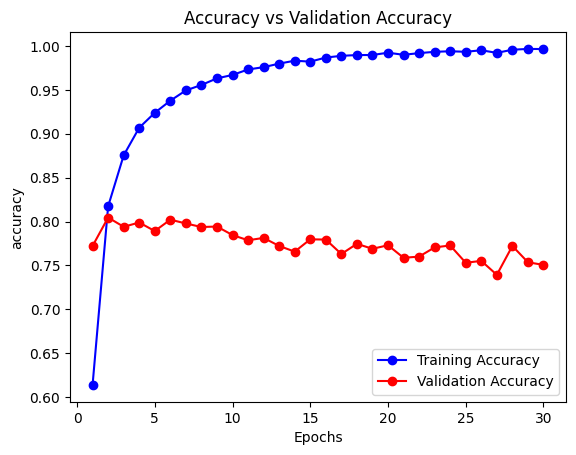

In [ ]:
## plotting accuracy vs validation accuracy
import matplotlib.pyplot as plt

def plot_accuracy(history):
  acc = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']
  epochs = range(1, len(acc) + 1)
  plt.plot(epochs, acc, 'bo-', label='Training Accuracy')
  plt.plot(epochs, val_accuracy, 'ro-', label='Validation Accuracy')
  plt.title("Accuracy vs Validation Accuracy")
  plt.legend()
  plt.xlabel('Epochs')
  plt.ylabel('accuracy')
  plt.show()
plot_accuracy(history)

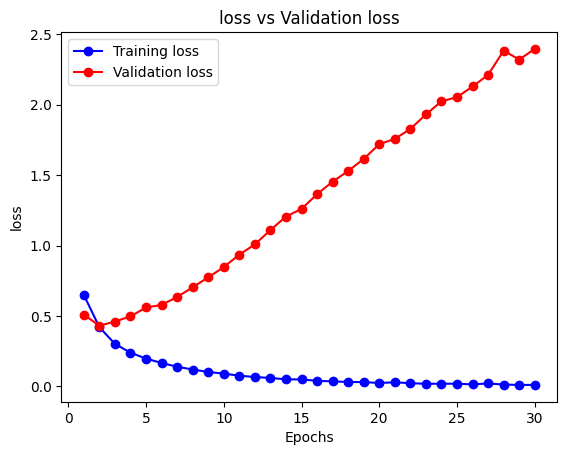

In [ ]:
## plotting loss vs validation loss
import matplotlib.pyplot as plt

def plot_accuracy(history):
  acc = history.history['loss']
  val_accuracy = history.history['val_loss']
  epochs = range(1, len(acc) + 1)
  plt.plot(epochs, acc, 'bo-', label='Training loss')
  plt.plot(epochs, val_accuracy, 'ro-', label='Validation loss')
  plt.title("loss vs Validation loss")
  plt.legend()
  plt.xlabel('Epochs')
  plt.ylabel('loss')
  plt.show()
plot_accuracy(history)

## Reducing Overfitting in Language Models

In [ ]:
## Adjusting the learning rate
from tensorflow.keras.optimizers import Adam
model.compile(loss='binary_crossentropy',
              optimizer=Adam(learning_rate=0.00001,beta_1=0.9, beta_2=0.999, amsgrad=False),
              metrics=['accuracy']
              )

In [ ]:
history = model.fit(training_padded, training_labels,
                    epochs=40,
                    validation_data=(testing_padded, testing_labels)
                  )

Epoch 1/40
719/719 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.9994 - loss: 0.0042 - val_accuracy: 0.7511 - val_loss: 2.3997
Epoch 2/40
719/719 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.9995 - loss: 0.0046 - val_accuracy: 0.7514 - val_loss: 2.4016
Epoch 3/40
719/719 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - accuracy: 0.9994 - loss: 0.0036 - val_accuracy: 0.7503 - val_loss: 2.4011
Epoch 4/40
719/719 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.9991 - loss: 0.0035 - val_accuracy: 0.7517 - val_loss: 2.4066
Epoch 5/40
719/719 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.9996 - loss: 0.0037 - val_accuracy: 0.7517 - val_loss: 2.4065
Epoch 6/40
719/719 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.9995 - loss: 0.0038 - val_accuracy: 0.7517 - val_loss: 2.4083
Epoch 7/40
719/719 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.9993 - loss: 0.0038 - val_accuracy: 0.7498 - val_loss: 2.4060
Epoch 8/40
719/719 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.9993 - loss: 0.0045 - val_accuracy: 0.

In [ ]:
## Exploring embedding dimensions
model = tf.keras.Sequential([
          tf.keras.layers.Embedding(20000, 12),
          tf.keras.layers.GlobalAveragePooling1D(),
          tf.keras.layers.Dense(24, activation='relu'),
          tf.keras.layers.Dense(1, activation='sigmoid')
        ])

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy']
              )

history = model.fit(training_padded, training_labels,
                    epochs=30,
                    validation_data=(testing_padded, testing_labels)
                  )

Epoch 1/30
719/719 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.5730 - loss: 0.6747 - val_accuracy: 0.7520 - val_loss: 0.5313
Epoch 2/30
719/719 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.8039 - loss: 0.4508 - val_accuracy: 0.7989 - val_loss: 0.4387
Epoch 3/30
719/719 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.8781 - loss: 0.3038 - val_accuracy: 0.8059 - val_loss: 0.4492
Epoch 4/30
719/719 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.9087 - loss: 0.2411 - val_accuracy: 0.8105 - val_loss: 0.4725
Epoch 5/30
719/719 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.9293 - loss: 0.1924 - val_accuracy: 0.8078 - val_loss: 0.5161
Epoch 6/30
719/719 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.9432 - loss: 0.1610 - val_accuracy: 0.7999 - val_loss: 0.5752
Epoch 7/30
719/719 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.9509 - loss: 0.1363 - val_accuracy: 0.7884 - val_loss: 0.6640
Epoch 8/30
719/719 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.9605 - loss: 0.1171 - val_accuracy: 0.

In [ ]:
## Using Dropout
model = tf.keras.Sequential([
          tf.keras.layers.Embedding(20000, 12),
          tf.keras.layers.GlobalAveragePooling1D(),
          tf.keras.layers.Dense(24, activation='relu'),
          tf.keras.layers.Dropout(.25),
          tf.keras.layers.Dense(1, activation='sigmoid')
        ])
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy']
              )

history = model.fit(training_padded, training_labels,
                    epochs=30,
                    validation_data=(testing_padded, testing_labels)
                  )

In [ ]:
## Using regularization